In [1]:
!pip install numpy pandas wfdb scikit-learn tensorflow scipy matplotlib

In [35]:
from google.colab import drive
import numpy as np
import pandas as pd
import wfdb
import os
import zipfile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
import pickle
from tensorflow.keras.regularizers import l2
from sklearn.utils import class_weight
from scipy.signal import butter, filtfilt, resample

In [36]:
np.random.seed(42)

In [37]:
print("Connect to Google Drive...")
drive.mount('/content/drive')

Connect to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [38]:
zip_path = '/content/drive/MyDrive/Data/mit-bih-arrhythmia-database-1.0.0.zip'
extract_path = '/content/mit-bih/'
print("Extract MIT-BIH file...")
try:
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_path)
except FileNotFoundError:
    print(f"Không tìm thấy file {zip_path}. Vui lòng kiểm tra đường dẫn.")
    exit()
mitbih_path = '/content/mit-bih/mit-bih-arrhythmia-database-1.0.0/'

Extract MIT-BIH file...


In [39]:
records = ['100', '101', '102', '103', '104', '105', '106', '107', '108', '109',
           '111', '112', '113', '114', '115', '116', '117', '118', '119', '121',
           '122', '123', '124', '200', '201', '202', '203', '205', '207', '208',
           '209', '210', '212', '213', '214', '215', '217', '219', '220', '221',
           '222', '223', '228', '230', '231', '232', '233', '234']

In [40]:
def bandpass_filter(data, lowcut=0.5, highcut=40.0, fs=360, order=2):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    return filtfilt(b, a, data)

In [41]:
def preprocess_mitbih_data(signal, original_fs=360, target_fs=200):
    target_samples = int(len(signal) * target_fs / original_fs)
    signal_resampled = resample(signal, target_samples)
    final_samples = int(len(signal_resampled) * 360 / target_fs)
    signal_resampled = resample(signal_resampled, final_samples)
    return signal_resampled

In [42]:
def standardize_segments(segments):
    standardized_segments = []
    for segment in segments:
        segment = (segment - np.mean(segment)) / np.std(segment)
        standardized_segments.append(segment)
    return np.array(standardized_segments)

In [43]:
print("Load MIT-BIH data...")
def load_mitbih_data():
    signals = []
    labels = []
    sampling_rate = 360
    segment_length = 200

    for rec in records:
        try:
            record = wfdb.rdrecord(os.path.join(mitbih_path, rec))
            annotation = wfdb.rdann(os.path.join(mitbih_path, rec), 'atr')
            signal = record.p_signal[:, 0]  # Lấy kênh MLII
            signal = bandpass_filter(signal, fs=sampling_rate)  # Lọc bandpass
            signal = preprocess_mitbih_data(signal)  # Tái lấy mẫu

            for i, ann_sample in enumerate(annotation.sample):
                start = max(0, ann_sample - segment_length // 2)
                end = start + segment_length
                if end <= len(signal):
                    segment = signal[start:end]
                    label = 0 if annotation.symbol[i] == 'N' else 1
                    signals.append(segment)
                    labels.append(label)
        except Exception as e:
            print(f"Lỗi khi xử lý bản ghi {rec}: {e}")
            continue

    signals = np.array(signals)
    signals = standardize_segments(signals)  # Chuẩn hóa từng đoạn
    return signals, np.array(labels)

X, y = load_mitbih_data()
if X.size == 0:
    print("Không tải được dữ liệu MIT-BIH. Vui lòng kiểm tra file và đường dẫn.")
    exit()

# Định dạng lại dữ liệu
X = X.reshape(X.shape[0], X.shape[1], 1)
y = to_categorical(y, num_classes=2)

# Chia dữ liệu thành tập train, validation, test
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

print(f"Kích thước tập huấn luyện: {X_train.shape}")
print(f"Kích thước tập xác thực: {X_val.shape}")
print(f"Kích thước tập kiểm tra: {X_test.shape}")

Load MIT-BIH data...
Kích thước tập huấn luyện: (78843, 200, 1)
Kích thước tập xác thực: (16895, 200, 1)
Kích thước tập kiểm tra: (16895, 200, 1)


In [44]:
y_train_labels = np.argmax(y_train, axis=1)
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(y_train_labels), y=y_train_labels)
class_weight_dict = {0: class_weights[0], 1: class_weights[1]}

In [ ]:
print("Đang xây dựng và huấn luyện mô hình...")
model = Sequential([
    Conv1D(filters=64, kernel_size=5, activation='relu', input_shape=(200, 1), kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=5, activation='relu', kernel_regularizer=l2(0.01)),
    MaxPooling1D(pool_size=2),
    LSTM(50, return_sequences=True),
    LSTM(50),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(2, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32,
                    class_weight=class_weight_dict, verbose=1)

Đang xây dựng và huấn luyện mô hình...


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_8 (Conv1D)               │ (None, 196, 64)        │           384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_8 (MaxPooling1D)  │ (None, 98, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_9 (Conv1D)               │ (None, 94, 32)         │        10,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_9 (MaxPooling1D)  │ (None, 47, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_8 (LSTM)                   │ (None, 47, 50)         │        16,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_9 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 64)             │         3,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 50,850 (198.63 KB)

 Trainable params: 50,850 (198.63 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 187s 74ms/step - accuracy: 0.8706 - loss: 0.3833 - val_accuracy: 0.9729 - val_loss: 0.1298
Epoch 2/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 194s 70ms/step - accuracy: 0.9646 - loss: 0.1550 - val_accuracy: 0.9719 - val_loss: 0.1084
Epoch 3/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 198s 69ms/step - accuracy: 0.9713 - loss: 0.1212 - val_accuracy: 0.9759 - val_loss: 0.0964
Epoch 4/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 213s 73ms/step - accuracy: 0.9746 - loss: 0.1062 - val_accuracy: 0.9811 - val_loss: 0.0768
Epoch 5/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 170s 69ms/step - accuracy: 0.9765 - loss: 0.0962 - val_accuracy: 0.9774 - val_loss: 0.0848
Epoch 6/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 201s 69ms/step - accuracy: 0.9774 - loss: 0.0921 - val_accuracy: 0.9806 - val_loss: 0.0747
Epoch 7/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 172s 70ms/step - accuracy: 0.9799 - loss: 0.0825 - val_accuracy: 0.9824 - val_loss: 0.0707
Epoch 8/30
2464/2464 ━━━━━━━━━━━━━━━━━━━━ 171s 69ms/step - accuracy: 

In [52]:
model_path = '/content/drive/MyDrive/Data/model_ecg.h5'
model.save(model_path)
print(f"Mô hình đã được lưu vào {model_path}")

Mô hình đã được lưu vào /content/drive/MyDrive/Data/model_ecg.h5


In [53]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Độ chính xác trên tập kiểm tra MIT-BIH: {test_acc:.4f}")

Độ chính xác trên tập kiểm tra MIT-BIH: 0.9886


In [55]:
test_predictions = model.predict(X_test, verbose=0)
test_predicted_labels = np.argmax(test_predictions, axis=1)
test_true_labels = np.argmax(y_test, axis=1)

Tỷ lệ đoạn bất thường trên tập kiểm tra MIT-BIH: 32.98%

Vẽ các dạng sóng bất thường từ tập kiểm tra MIT-BIH...


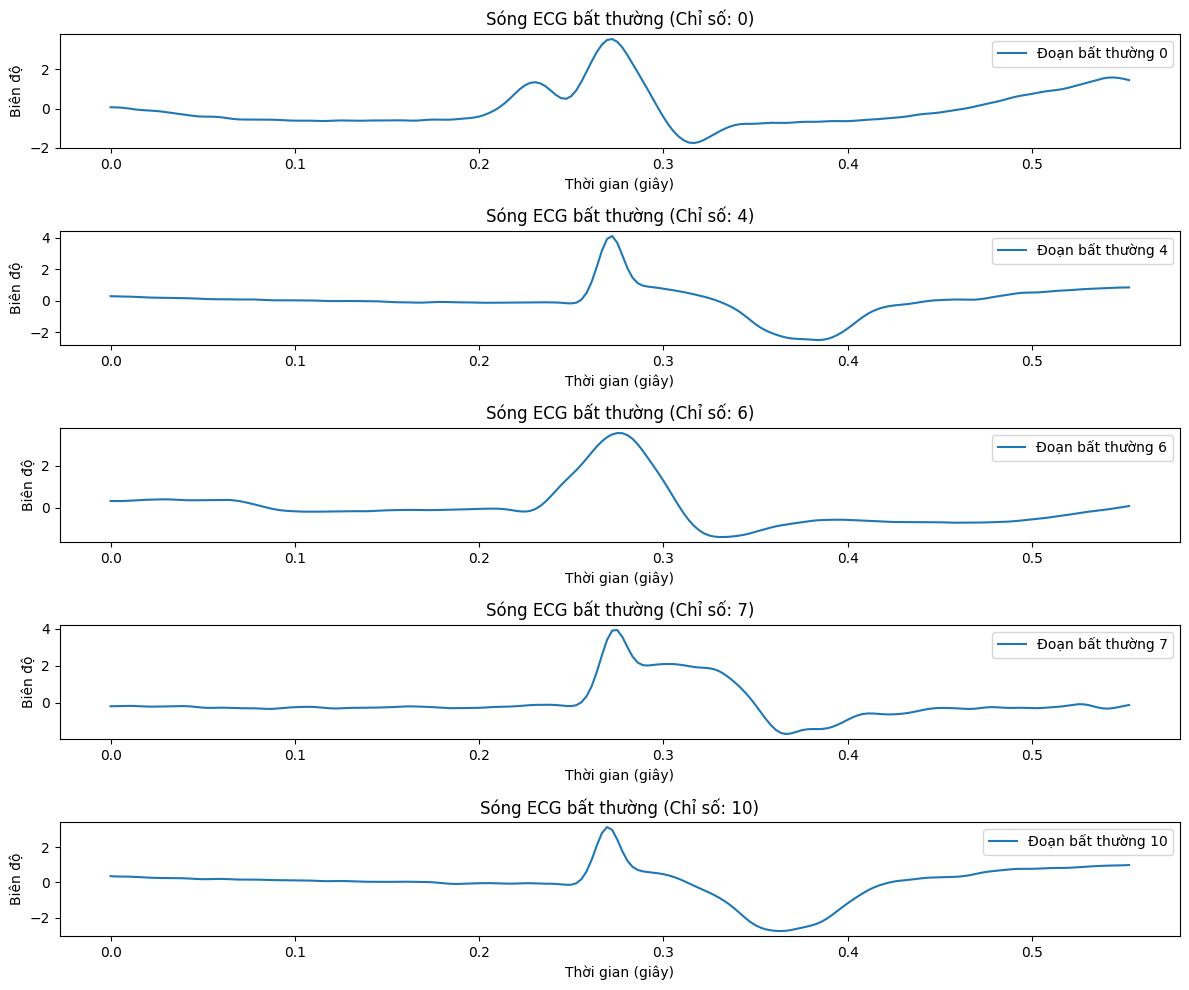

In [56]:
test_abnormal_percentage = (np.sum(test_predicted_labels == 1) / len(test_predicted_labels)) * 100
print(f"Tỷ lệ đoạn bất thường trên tập kiểm tra MIT-BIH: {test_abnormal_percentage:.2f}%")
# In các dạng sóng bất thường từ tập kiểm tra MIT-BIH
print("\nVẽ các dạng sóng bất thường từ tập kiểm tra MIT-BIH...")
abnormal_indices = np.where(test_predicted_labels == 1)[0]
num_to_plot = min(5, len(abnormal_indices))  # Giới hạn vẽ tối đa 5 sóng bất thường
if num_to_plot == 0:
    print("Không có đoạn bất thường nào trong tập kiểm tra.")
else:
    plt.figure(figsize=(12, 2 * num_to_plot))
    time = np.arange(200) / 360  # Thời gian cho 200 mẫu ở 360 Hz
    for i, idx in enumerate(abnormal_indices[:num_to_plot]):
        plt.subplot(num_to_plot, 1, i + 1)
        plt.plot(time, X_test[idx].flatten(), label=f'Đoạn bất thường {idx}')
        plt.title(f'Sóng ECG bất thường (Chỉ số: {idx})')
        plt.xlabel('Thời gian (giây)')
        plt.ylabel('Biên độ')
        plt.legend()
    plt.tight_layout()
    plt.show()

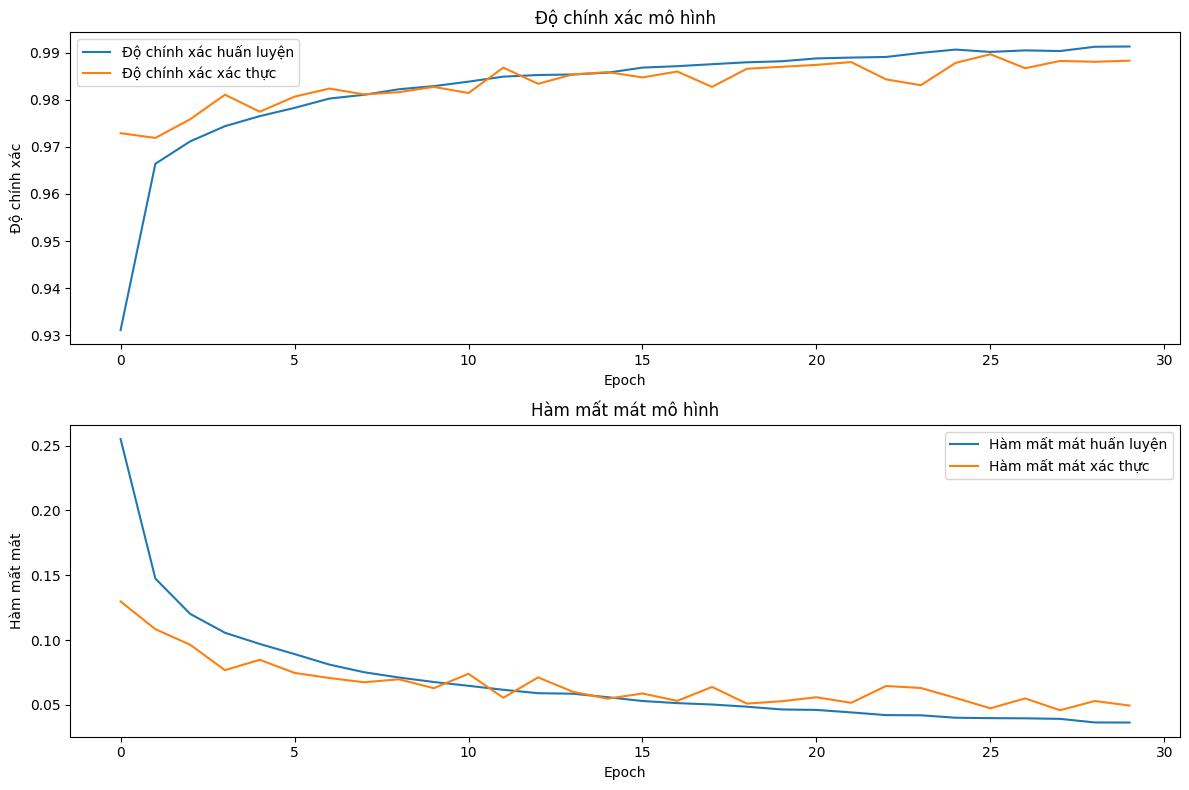

In [57]:
plt.figure(figsize=(12, 8))

# Biểu đồ 1: Độ chính xác
plt.subplot(2, 1, 1)
plt.plot(history.history['accuracy'], label='Độ chính xác huấn luyện')
plt.plot(history.history['val_accuracy'], label='Độ chính xác xác thực')
plt.title('Độ chính xác mô hình')
plt.xlabel('Epoch')
plt.ylabel('Độ chính xác')
plt.legend()

# Biểu đồ 2: Hàm mất mát
plt.subplot(2, 1, 2)
plt.plot(history.history['loss'], label='Hàm mất mát huấn luyện')
plt.plot(history.history['val_loss'], label='Hàm mất mát xác thực')
plt.title('Hàm mất mát mô hình')
plt.xlabel('Epoch')
plt.ylabel('Hàm mất mát')
plt.legend()

plt.tight_layout()
plt.show()